## Importing relevant Libraries

In [1]:
from attention import AttentionLayer

In [2]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option('display.max_colwidth',200)
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Reading Data
Then data has been taken from Kaggle:-
https://www.kaggle.com/snap/amazon-fine-food-reviews/notebooks

In [3]:
data=pd.read_csv('Reviews.csv',nrows=100000)

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [5]:
for i in range(10):
    print(data['Text'][i])
    print('\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

# PREPROCESSING
We will drop unwanted symbols,characters,etc. from the data so that they don't affect our objective.

In [6]:
from contraction import contraction_mapping

**We will use the following dictionary for expanding the contractions present in the comments.**

In [7]:
contraction_mapping

{"ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'm

## a.) Text Cleaning

In [8]:
stop_words=set(stopwords.words('english'))

In [9]:
def text_cleaner(text):
    new_str=text.lower()
    new_str=BeautifulSoup(new_str,'lxml').text
    new_str=re.sub(r'\([^)]*\)', '', new_str)
    new_str=re.sub('"','', new_str)
    new_str=' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_str.split(' ')])
    new_str=re.sub(r"'s\b","",new_str)
    new_str=re.sub("[^a-zA-Z]", " ", new_str) 
    tokens=[w for w in new_str.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()



In [10]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [11]:
text_cleaner(data['Text'][0])

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [12]:
cleaned_text=[]
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

## b.) Summary Cleaning

In [13]:
for i in range(10):
    print(data['Summary'][i])
    print('\n')

Good Quality Dog Food


Not as Advertised


"Delight" says it all


Cough Medicine


Great taffy


Nice Taffy


Great!  Just as good as the expensive brands!


Wonderful, tasty taffy


Yay Barley


Healthy Dog Food




In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', str(text))
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [15]:
cleaned_summary=[]

for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [16]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('',np.nan,inplace=True)
data.dropna(axis=0,inplace=True)

**We also have to pad the summary with _START_ and _END_ tags.**

In [17]:
data['cleaned_summary']=data['cleaned_summary'].apply(lambda x:'_START_' + x + '_END_')

In [18]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_good quality dog food _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_not as advertised _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_delight says it all _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_cough medicine _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal

# Data Analysis

In [19]:
import matplotlib.pyplot as plt
text_word_count=[]
summary_word_count=[]

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))
    
for j in data['cleaned_summary']:
    summary_word_count.append(len(j.split()))    
    
length_df=pd.DataFrame({'text':text_word_count,'summary':summary_word_count})
length_df

,text,summary
0,23,5
1,18,4
2,39,5
3,17,3
4,13,3
...,...,...
99909,7,2
99910,91,4
99911,20,3
99912,28,2


In [27]:
length_df.describe([0.1,0.2,0.9,0.95,0.99]).T

,count,mean,std,min,10%,20%,50%,90%,95%,99%,max
text,99914.0,38.374692,36.825957,2.0,12.0,15.0,27.0,76.0,103.0,182.0,1212.0
summary,99914.0,5.012621,2.487182,2.0,2.0,3.0,4.0,8.0,10.0,13.0,28.0


array([[<AxesSubplot:title={'center':'text'}>,
        <AxesSubplot:title={'center':'summary'}>]], dtype=object)

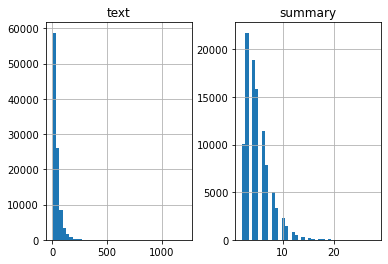

In [23]:
length_df.hist(bins=40)

**Let us set the maximum length for text and summaries.**

In [29]:
max_len_text=80 
max_len_summary=10

### Let's split the data

In [55]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


# Preparing the tokenizer

## a.) Text Tokenixer

In [56]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))


x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)


x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

## b.) Summary Tokenizer

In [57]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))


y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 


y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

# Model Building

In [38]:
from keras import backend as K
K.clear_session()
latent_dim=500

#Encoder
encoder_inputs=Input(shape=(max_len_text,))
enc_emb=Embedding(x_voc_size,latent_dim,trainable=True)(encoder_inputs)

#LSTM-1
encoder_lstm1=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1,state_h1,state_c1 = encoder_lstm1(enc_emb)

#LSTM-2
encoder_lstm2=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2,state_h2,state_c2 = encoder_lstm2(encoder_output1)

#LSTM-3
encoder_lstm3=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h,state_c = encoder_lstm3(encoder_output2)


#Decoder
decoder_inputs=Input(shape=(None,))
dec_emb_layer=Embedding(y_voc_size,latent_dim,trainable=True)
dec_emb=dec_emb_layer(decoder_inputs)

decoder_lstm=LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,decoder_fwd_state,decoder_back_state=decoder_lstm(dec_emb,initial_state=[state_h,state_c])

#Attention Layer
attn_layer=AttentionLayer(name='attention_layer')
attn_out,attn_states=attn_layer([encoder_outputs,decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25986000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [40]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 89922 samples, validate on 9992 samples
Epoch 1/50
